In [1]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../data/df_final.csv',index_col='date', parse_dates=True)

In [3]:
df.head()

,eurusd,jpyusd,gbpusd,nq,sp500,nikkei,ftse,gdp_us,gdp_uk,gdp_jp,...,jpyusd_trend_lag_1,jpyusd_trend_lag_2,jpyusd_trend_lag_3,jpyusd_trend_lag_4,jpyusd_trend_lag_5,gbpusd_trend_lag_1,gbpusd_trend_lag_2,gbpusd_trend_lag_3,gbpusd_trend_lag_4,gbpusd_trend_lag_5
date,,,,,,,,,,,,,,,,,,,,,
2004-01-08,1.277498,0.009419,1.833887,1531.0,1131.920044,10837.650391,4494.200195,11923447.0,322790.0,529365100.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2004-01-09,1.285892,0.009383,1.848087,1521.5,1121.859985,10965.049805,4466.299805,11923447.0,322790.0,529365100.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2004-01-12,1.274096,0.009381,1.845597,1544.5,1127.229980,10965.049805,4449.600098,11923447.0,322790.0,529365100.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2004-01-13,1.278593,0.009413,1.848805,1528.5,1121.219971,10849.679688,4440.100098,11923447.0,322790.0,529365100.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2004-01-14,1.265102,0.009413,1.831703,1537.5,1130.520020,10863.000000,4461.399902,11923447.0,322790.0,529365100.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


In [4]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler()

In [5]:
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Multiple Linear Regression

## EURUSD

In [8]:
df.columns

Index(['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear'],
      dtype='object')

In [9]:
# Definir características y variables target
features = df.drop(columns=['eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change'])
targets = ['eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change']

In [10]:
# Función para optimizar los hiperparámetros
def objective(trial, X, y, model_type):
    if model_type == 'Linear Regression':
        model = LinearRegression()
    elif model_type == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_type == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif model_type == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        num_leaves = trial.suggest_int('num_leaves', 20, 200)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        model = LGBMRegressor(n_estimators=n_estimators, num_leaves=num_leaves, learning_rate=learning_rate, random_state=42)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [11]:
# Función para entrenar y evaluar modelos
def train_and_evaluate(df, target):
    X = df.drop(columns=targets)
    y = df[target]
    
    # Normalizar la variable target
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    # Definir modelos y sus estudios de optimización
    models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM']
    best_params = {}
    predictions = {}
    
    for model_type in models:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X, y_scaled, model_type), n_trials=50)
        best_params[model_type] = study.best_params
        
        # Entrenar el modelo con los mejores hiperparámetros
        if model_type == 'Linear Regression':
            model = LinearRegression()
        elif model_type == 'Random Forest':
            model = RandomForestRegressor(**study.best_params, random_state=42)
        elif model_type == 'XGBoost':
            model = XGBRegressor(**study.best_params, random_state=42)
        elif model_type == 'LightGBM':
            model = LGBMRegressor(**study.best_params, random_state=42)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
        
        pipeline.fit(X, y_scaled)
        preds_scaled = pipeline.predict(X)
        
        # Invertir la normalización de las predicciones
        preds = target_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        predictions[model_type] = preds
    
    return best_params, predictions

In [ ]:
# Entrenar y evaluar los modelos para cada variable target
results = {}
predictions = {}

for target in targets:
    print(f"Evaluando modelos para: {target}")
    res, preds = train_and_evaluate(df, target)
    results[target] = res
    predictions[target] = preds
    for model, params in results[target].items():
        print(f"{model}: {params}")

In [15]:
results_df

,eurusd_pct_change,jpyusd_pct_change,gbpusd_pct_change
Linear Regression,{},{},{}
Random Forest,"{'n_estimators': 89, 'max_depth': 3}","{'n_estimators': 150, 'max_depth': 2}","{'n_estimators': 69, 'max_depth': 2}"
XGBoost,"{'n_estimators': 160, 'max_depth': 3, 'learnin...","{'n_estimators': 110, 'max_depth': 2, 'learnin...","{'n_estimators': 131, 'max_depth': 2, 'learnin..."
LightGBM,"{'n_estimators': 48, 'num_leaves': 136, 'learn...","{'n_estimators': 52, 'num_leaves': 109, 'learn...","{'n_estimators': 41, 'num_leaves': 200, 'learn..."


In [14]:
# Crear una tabla con los mejores hiperparámetros
results_df = pd.DataFrame(results)
print("\nMejores hiperparámetros:")
print(results_df)



Mejores hiperparámetros:
                                                   eurusd_pct_change  \
Linear Regression                                                 {}   
Random Forest                   {'n_estimators': 89, 'max_depth': 3}   
XGBoost            {'n_estimators': 160, 'max_depth': 3, 'learnin...   
LightGBM           {'n_estimators': 48, 'num_leaves': 136, 'learn...   

                                                   jpyusd_pct_change  \
Linear Regression                                                 {}   
Random Forest                  {'n_estimators': 150, 'max_depth': 2}   
XGBoost            {'n_estimators': 110, 'max_depth': 2, 'learnin...   
LightGBM           {'n_estimators': 52, 'num_leaves': 109, 'learn...   

                                                   gbpusd_pct_change  
Linear Regression                                                 {}  
Random Forest                   {'n_estimators': 69, 'max_depth': 2}  
XGBoost            {'n_estimators': 131

In [71]:
#results_df.to_csv('shall_reg_hyperp.csv')

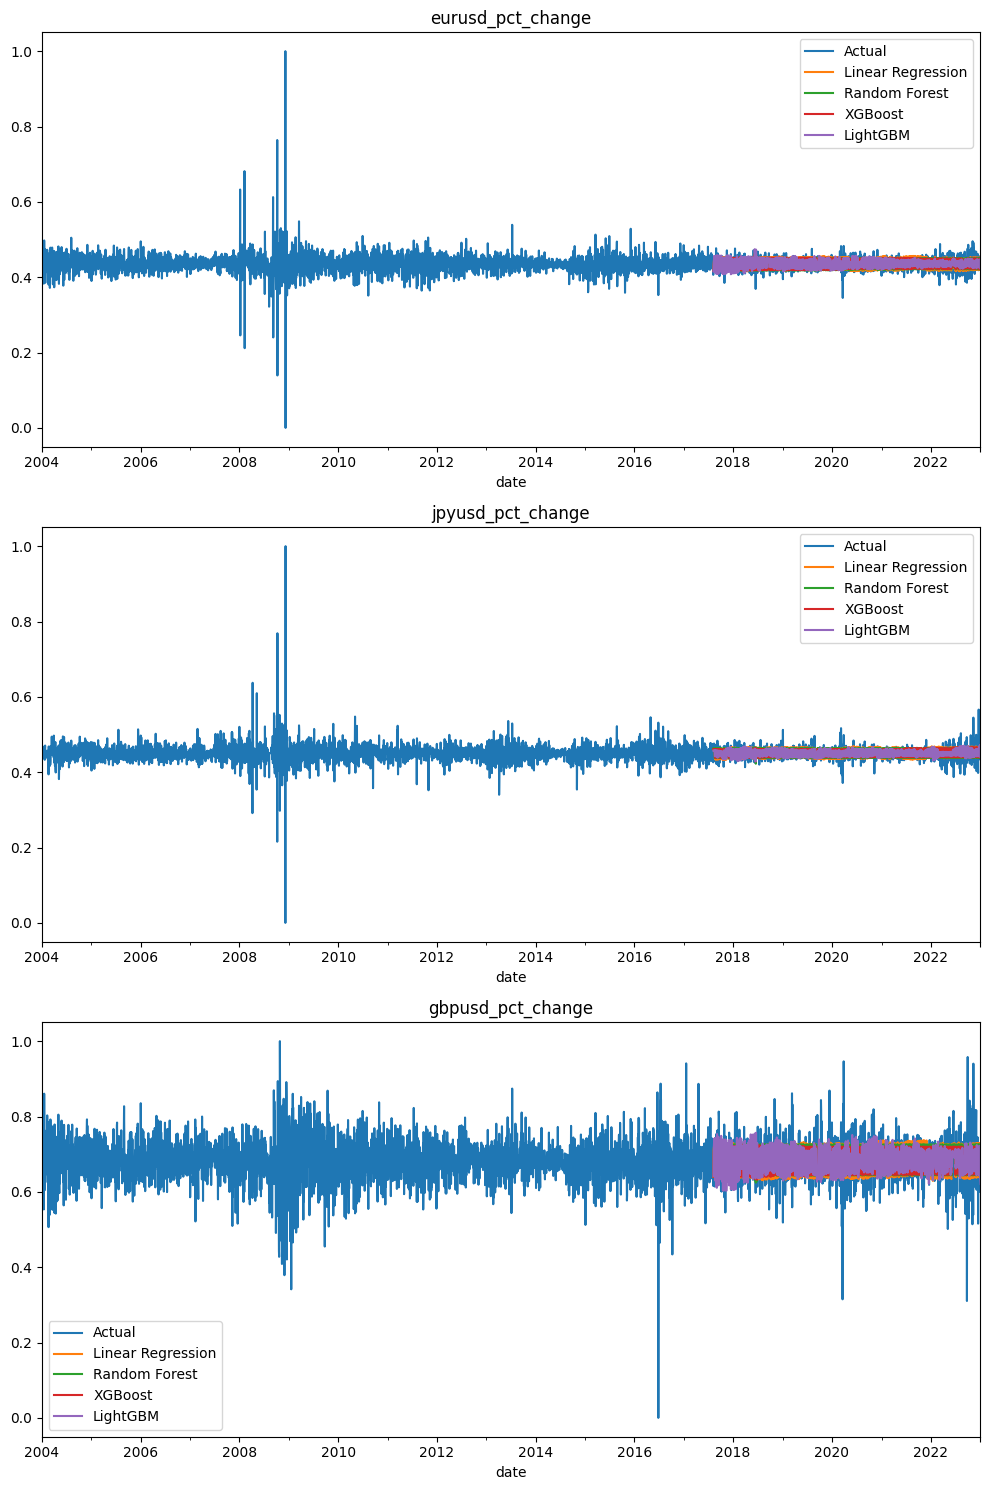

In [16]:
# Visualizar predicciones
fig, axes = plt.subplots(nrows=len(targets), ncols=1, figsize=(10, 15))

for i, target in enumerate(targets):
    ax = axes[i]
    df[target].plot(ax=ax, label='Actual', title=target)
    for model_name, preds in predictions[target].items():
        ax.plot(df.index, preds, label=model_name)
    ax.legend()

plt.tight_layout()
plt.show()


# XGB with lagged variables dataset

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## eurusd

In [76]:
# Definir la variable objetivo
target = 'eurusd_pct_change'

# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']


In [77]:
# Separar características (X) y objetivo (y)
X = df.drop(columns=t, axis=1)  # Excluir las variables del periodo presente
y = df[target]

In [12]:
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Validación cruzada adaptada a series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


In [79]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)


[I 2024-06-24 19:49:11,438] A new study created in memory with name: no-name-1ec7ad27-7d73-490c-951a-7c1d18644485
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  """Gets the number of xgboost boosting rounds."""
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  """Gets the number of xgboost boosting rounds."""
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  """Gets the 

Best hyperparameters:  {'n_estimators': 919, 'learning_rate': 0.0675781190100918, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7600994460320993, 'colsample_bytree': 0.9952405760142711}


Best hyperparameters:  {'n_estimators': 919, 'learning_rate': 0.0675781190100918, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7600994460320993, 'colsample_bytree': 0.9952405760142711}

In [80]:
# Obtener los mejores hiperparámetros
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros en todo el conjunto de datos
model = xgb.XGBRegressor(**best_params)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9952405760142711, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0675781190100918, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=919, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

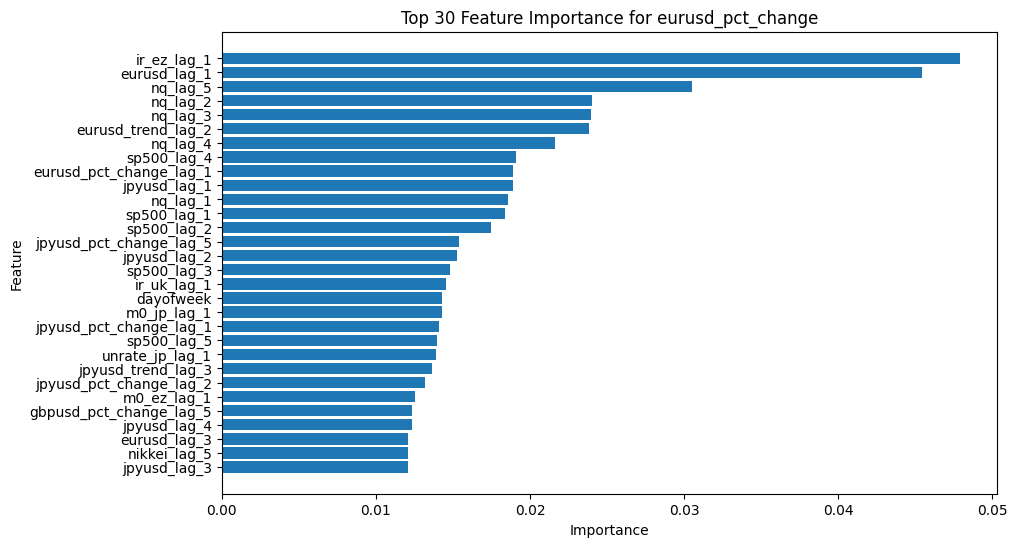

In [81]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 20 características más importantes
top_30_features = importance_df.head(30)

# Graficar la importancia de las 20 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['feature'], top_30_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Feature Importance for {target}')
plt.gca().invert_yaxis()
plt.show()


## jpyusd

In [8]:
# Definir la variable objetivo
target = 'jpyusd_pct_change'

# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']

In [9]:
# Separar características (X) y objetivo (y)
X = df.drop(columns=t, axis=1)  # Excluir las variables del periodo presente
y = df[target]

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)


[I 2024-06-26 08:14:03,263] A new study created in memory with name: no-name-0c68a726-b04d-4760-a860-8cf2aada1c97
[I 2024-06-26 08:14:06,838] Trial 0 finished with value: 1.044456661607592 and parameters: {'n_estimators': 212, 'learning_rate': 0.03636022807566391, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.553371202237631, 'colsample_bytree': 0.8159822708211977}. Best is trial 0 with value: 1.044456661607592.
[I 2024-06-26 08:14:14,253] Trial 1 finished with value: 1.1278487911244512 and parameters: {'n_estimators': 430, 'learning_rate': 0.09218213422540082, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9031056318823352, 'colsample_bytree': 0.8473017369649929}. Best is trial 0 with value: 1.044456661607592.
[I 2024-06-26 08:14:42,006] Trial 2 finished with value: 1.1131193251376672 and parameters: {'n_estimators': 866, 'learning_rate': 0.08705335488643069, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8041703083633739, 'colsample_bytree': 0.8327111111573231}.

Best hyperparameters:  {'n_estimators': 598, 'learning_rate': 0.02599320935409307, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6277981232632368, 'colsample_bytree': 0.9803393420255615}


Best hyperparameters:  {'n_estimators': 598, 'learning_rate': 0.02599320935409307, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6277981232632368, 'colsample_bytree': 0.9803393420255615}


In [14]:
# Obtener los mejores hiperparámetros
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros en todo el conjunto de datos
model = xgb.XGBRegressor(**best_params)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9803393420255615, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02599320935409307, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=598, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

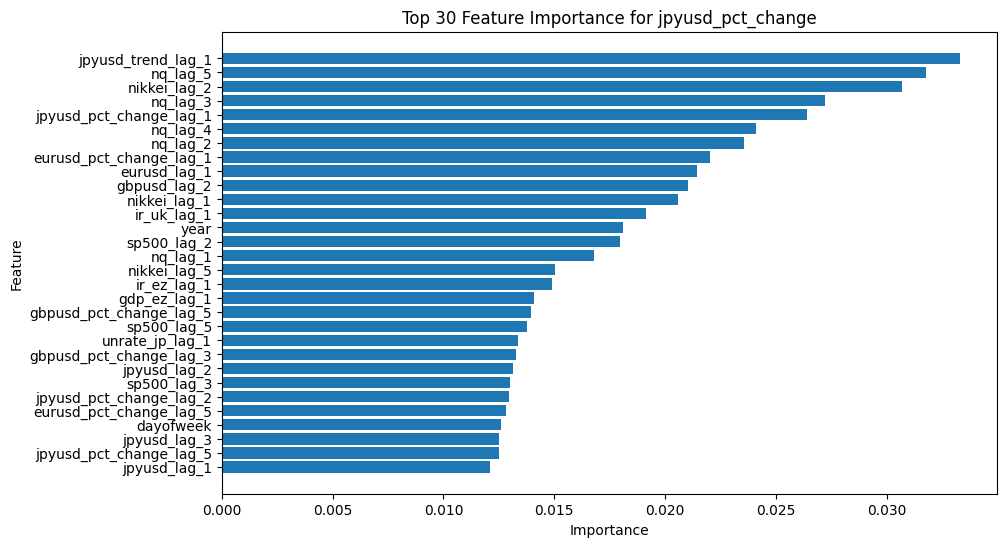

In [15]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 30 características más importantes
top_30_features = importance_df.head(30)

# Graficar la importancia de las 30 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['feature'], top_30_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Feature Importance for {target}')
plt.gca().invert_yaxis()
plt.show()

## gbpusd

In [16]:
# Definir la variable objetivo
target = 'gbpusd_pct_change'

# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']

In [17]:
# Separar características (X) y objetivo (y)
X = df.drop(columns=t, axis=1)  # Excluir las variables del periodo presente
y = df[target]

In [18]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)

[I 2024-06-26 08:16:08,515] A new study created in memory with name: no-name-58427e75-4b6a-4472-a7f1-e456e84d1726
[I 2024-06-26 08:16:16,351] Trial 0 finished with value: 1.1769736664470238 and parameters: {'n_estimators': 827, 'learning_rate': 0.018148131966692606, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7043852867563982, 'colsample_bytree': 0.841699088874972}. Best is trial 0 with value: 1.1769736664470238.
[I 2024-06-26 08:16:23,919] Trial 1 finished with value: 1.282383268848275 and parameters: {'n_estimators': 922, 'learning_rate': 0.07471492936262958, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5569317515477816, 'colsample_bytree': 0.9572210682221116}. Best is trial 0 with value: 1.1769736664470238.
[I 2024-06-26 08:16:32,781] Trial 2 finished with value: 1.1471261151821845 and parameters: {'n_estimators': 378, 'learning_rate': 0.024118626612907555, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9542607636343903, 'colsample_bytree': 0.91618588041403

Best hyperparameters:  {'n_estimators': 378, 'learning_rate': 0.024118626612907555, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9542607636343903, 'colsample_bytree': 0.9161858804140355}


Best hyperparameters:  {'n_estimators': 378, 'learning_rate': 0.024118626612907555, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9542607636343903, 'colsample_bytree': 0.9161858804140355}



In [19]:
# Obtener los mejores hiperparámetros
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros en todo el conjunto de datos
model = xgb.XGBRegressor(**best_params)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9161858804140355, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.024118626612907555, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=378, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

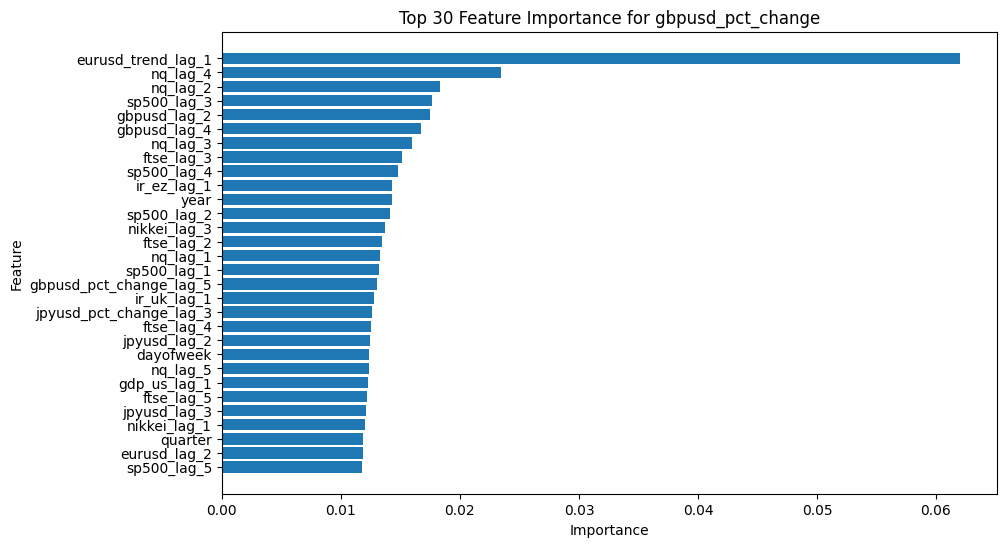

In [20]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 30 características más importantes
top_30_features = importance_df.head(30)

# Graficar la importancia de las 30 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['feature'], top_30_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Feature Importance for {target}')
plt.gca().invert_yaxis()
plt.show()
